# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용

## STEP #1: IMPORT LIBRARIES

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import sys

np.set_printoptions(threshold=sys.maxsize)

## STEP #2: Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴  

- Fine Tuning 없이 사용하기 위해 Full Model download

In [2]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [3]:
mobilenet = Sequential([
                    hub.KerasLayer(url, input_shape=(224,224,3))]
                    )

In [4]:
mobilenet.input, mobilenet.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

# STEP #3: PRE-TRAINED MOBILENET 평가

임의의 사진을 internet에서 가져온다

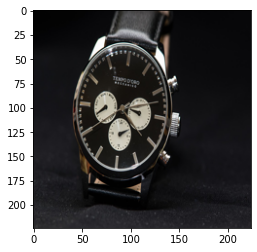

In [5]:
from PIL import Image
from urllib import request
from io import BytesIO
url = "https://github.com/ironmanciti/MachineLearningBasic/blob/master/datasets/TransferLearningData/watch.jpg?raw=true"
res = request.urlopen(url).read()
Sample_Image = Image.open(BytesIO(res)).resize((224, 224))

plt.imshow(Sample_Image)

In [6]:
x = preprocess_input(np.array(Sample_Image))
x.shape

(224, 224, 3)

In [8]:
predicted_class = mobilenet.predict(np.expand_dims(x, axis = 0))

In [9]:
decode_predictions(predicted_class[:, 1:])  # 첫번째 label은 background

49152/35363 [=========================================] - 0s 0us/step


[[('n04328186', 'stopwatch', 9.720387),
  ('n02708093', 'analog_clock', 8.041001),
  ('n03706229', 'magnetic_compass', 6.8818045),
  ('n04548280', 'wall_clock', 6.6048098),
  ('n03075370', 'combination_lock', 4.9255257)]]

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


In [11]:
print(imagenet_labels[:30])

['background' 'tench' 'goldfish' 'great white shark' 'tiger shark'
 'hammerhead' 'electric ray' 'stingray' 'cock' 'hen' 'ostrich' 'brambling'
 'goldfinch' 'house finch' 'junco' 'indigo bunting' 'robin' 'bulbul' 'jay'
 'magpie' 'chickadee' 'water ouzel' 'kite' 'bald eagle' 'vulture'
 'great grey owl' 'European fire salamander' 'common newt' 'eft'
 'spotted salamander']


Text(0.5, 1.0, 'Predicted Class is: Stopwatch')

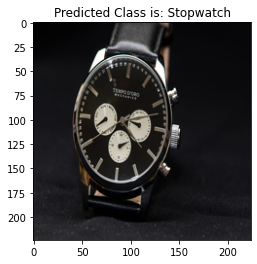

In [12]:
plt.imshow(Sample_Image)
predicted_class = imagenet_labels[np.argmax(predicted_class)]
plt.title("Predicted Class is: " + predicted_class.title())

## STEP #4: 특정 domain 의 Batch Image 에 대한 MobileNet 평가 - No Fine Tuning 

### MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것 예상

In [13]:
# Specify path of the flowers dataset
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
    untar=True)

228827136/228813984 [==============================] - 2s 0us/step


In [14]:
image_generator = ImageDataGenerator(
            preprocessing_function=preprocess_input)

flowers_data = image_generator.flow_from_directory(flowers_data_path, 
                    target_size=(224, 224), batch_size = 64, shuffle = True)

Found 3670 images belonging to 5 classes.


- flower data 는 5 개의 class 로 구성

In [15]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [16]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 10 개 image 시각화

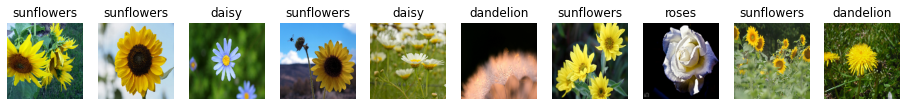

In [17]:
fig = plt.figure(figsize=(16, 8))

for i in range(10):
    sp = fig.add_subplot(1, 10, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    sp.imshow(img)
    sp.set_title(class_names[idx])
    sp.axis('off')

- 임의의 꽃 image 1 개를 선택하여 prediction 비교

In [18]:
prediction = mobilenet.predict(input_batch[2:3])
prediction.shape

(1, 1001)

In [19]:
decode_predictions(prediction[:, 1:])  

[[('n11939491', 'daisy', 9.195391),
  ('n04548280', 'wall_clock', 6.3854165),
  ('n04590129', 'window_shade', 6.3178196),
  ('n04589890', 'window_screen', 5.468238),
  ('n04404412', 'television', 5.0447907)]]

# STEP #5: 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain 

### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [20]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [21]:
extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

In [22]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [23]:
extractor_layer.trainable = False

In [24]:
# Build a model with two pieces:
#    (1)  MobileNet Feature Extractor 
#    (2)  Dense Network (classifier) added at the end 

model = Sequential([
  extractor_layer,
  Dense(flowers_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check

In [26]:
predictions = model(input_batch)

In [27]:
predictions.shape

TensorShape([64, 5])

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 16s 224ms/step - loss: 0.8505 - accuracy: 0.6866
Epoch 2/30
58/58 [==============================] - 13s 223ms/step - loss: 0.4669 - accuracy: 0.8368
Epoch 3/30
58/58 [==============================] - 13s 223ms/step - loss: 0.3835 - accuracy: 0.8706
Epoch 4/30
58/58 [==============================] - 13s 221ms/step - loss: 0.3362 - accuracy: 0.8899
Epoch 5/30
58/58 [==============================] - 13s 222ms/step - loss: 0.2978 - accuracy: 0.9027
Epoch 6/30
58/58 [==============================] - 13s 220ms/step - loss: 0.2722 - accuracy: 0.9120
Epoch 7/30
58/58 [==============================] - 13s 221ms/step - loss: 0.2503 - accuracy: 0.9199
Epoch 8/30
58/58 [==============================] - 13s 220ms/step - loss: 0.2349 - accuracy: 0.9272
Epoch 9/30
58/58 [==============================] - 13s 220ms/step - loss: 0.2177 - accuracy: 0.9294
Epoch 10/30
58/58 [==============================] - 13s 219ms/step - loss: 0.2062 - accura

# STEP #6: Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

In [30]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

array([3, 3, 0, 3, 0, 1, 3, 2, 3, 1, 4, 3, 3, 4, 4, 2, 3, 1, 1, 0, 4, 4,
       0, 3, 4, 2, 1, 1, 1, 3, 3, 2, 4, 4, 4, 4, 1, 2, 1, 1, 0, 4, 1, 4,
       0, 4, 3, 4, 4, 0, 3, 4, 3, 2, 1, 1, 3, 4, 2, 3, 1, 1, 4, 3])

In [31]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([3, 3, 0, 3, 0, 1, 3, 2, 3, 1, 4, 3, 3, 4, 4, 2, 3, 1, 1, 0, 4, 4,
       0, 3, 4, 2, 1, 1, 1, 3, 3, 2, 4, 4, 4, 4, 1, 2, 1, 1, 0, 4, 1, 4,
       0, 4, 3, 4, 4, 0, 3, 4, 3, 2, 1, 1, 3, 4, 2, 3, 1, 1, 4, 3])

In [33]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'100.00 %'

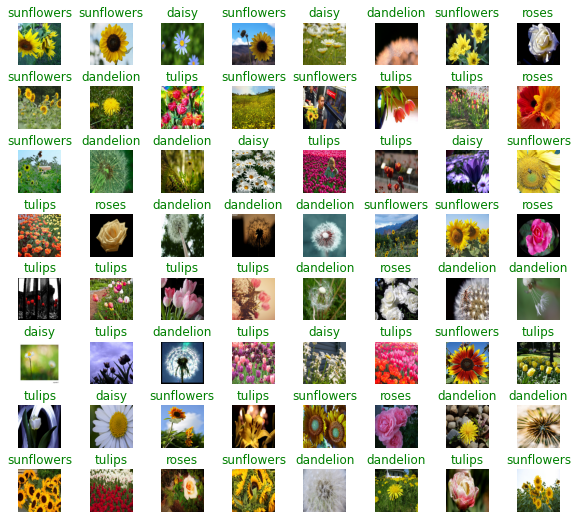

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
  plt.subplot(8, 8, i+1)
  img = ((input_batch[i]+1)*127.5).astype(np.uint8)
  plt.imshow(img)
  color = "green" if y_pred[i] == y_true[i] else "red"
  plt.title(class_names[y_pred[i]], color=color)
  plt.axis('off')
